In [1]:
import xarray as xr
import utils
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import Landsat_processing as lp
import numpy as np

In [2]:
site = 'US-A32'
path_to_landsat = f'gs://rangelands-dev/Flux_Towers_v2/{site}/baseline/landsat/Landsat_brdf_corr_bp_corr.nc'
path_to_starfm = f'gs://rangelands-dev/Flux_Towers_v2/{site}/baseline/starfm/starfm_bp_corr.nc'
path_to_starfm_istsg = f'gs://rangelands-dev/Flux_Towers_v2/{site}/baseline/starfm/starfm_bp_corr_istsg.nc'

path_to_mod_filled = f'gs://rangelands-dev/Flux_Towers_v2/{site}/baseline/starfm/starfm_bp_corr_mod_filled_istsg.nc'
#path_to_f1 = f'gs://rangelands-dev/Flux_Towers_v2/{site}/baseline/starfm/starfm_bp_corr_ls7_filled_3_02_istsg.nc'
path_to_f1 = f'gs://rangelands-dev/Flux_Towers_v2/{site}/baseline/starfm/starfm_bp_corr_ls_filled_istsg.nc'


In [3]:
landsat = utils.load_dataset(path_to_landsat)
starfm = utils.load_dataset(path_to_starfm)
starfm_istsg = utils.load_dataset(path_to_starfm_istsg)
mod_filled = utils.load_dataset(path_to_mod_filled)
f1 = utils.load_dataset(path_to_f1)

landsat = landsat.sel(time=slice(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-12-31')))
landsat = lp.mask_landsat_clouds_snow_water(landsat)
landsat['ndvi'] = (landsat['nir08'] - landsat['red'])/ (landsat['nir08'] + landsat['red'])
landsat = landsat[['ndvi']]

starfm = starfm.sel(time=slice(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-12-31')))
starfm['ndvi'] = (starfm['nir08'] - starfm['red'])/ (starfm['nir08'] + starfm['red'])
starfm = starfm[['ndvi']]
starfm['ndvi'] = starfm['ndvi'].where((starfm['ndvi']>0) & (starfm['ndvi']<1))

starfm_istsg = starfm_istsg.sel(time=slice(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-12-31')))
mod_filled = mod_filled.sel(time=slice(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-12-31')))
f1 = f1.sel(time=slice(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-12-31')))


In [4]:
valid_mask = np.nanmax(landsat['ndvi'], axis=0)
valid_mask = np.where(~np.isnan(valid_mask), 1, 0)
sum_valid_mask = np.nansum(valid_mask)
valid_mask_da = xr.DataArray(valid_mask, dims=('y', 'x'))

# Count NaN pixels in each time slice (within valid area)
n_nan = (valid_mask_da * xr.ufuncs.isnan(landsat['ndvi'])).sum(dim=('y', 'x'))

# Mask for time slices where valid fraction is less than 0.5
invalid_fraction = n_nan / sum_valid_mask

# Set all pixels to NaN for those time slices
landsat['ndvi'] = landsat['ndvi'].where(invalid_fraction < 0.6)

In [5]:
valid_mask = np.nanmax(starfm['ndvi'], axis=0)
valid_mask = np.where(~np.isnan(valid_mask), 1, 0)
sum_valid_mask = np.nansum(valid_mask)
valid_mask_da = xr.DataArray(valid_mask, dims=('y', 'x'))

# Count NaN pixels in each time slice (within valid area)
n_nan = (valid_mask_da * xr.ufuncs.isnan(starfm['ndvi'])).sum(dim=('y', 'x'))

# Mask for time slices where valid fraction is less than 0.5
invalid_fraction = n_nan / sum_valid_mask

# Set all pixels to NaN for those time slices
starfm['ndvi'] = starfm['ndvi'].where(invalid_fraction < 0.6)

In [6]:
landsat_mean = landsat.mean(dim=['y', 'x'])
starfm_mean = starfm.mean(dim=['y', 'x'])

starfm_istsg_mean = starfm_istsg.mean(dim=['y', 'x'])
mod_filled_mean = mod_filled.mean(dim=['y', 'x'])
f1_mean = f1.mean(dim=['y', 'x'])


In [7]:
pal = sns.color_palette('pastel',5)

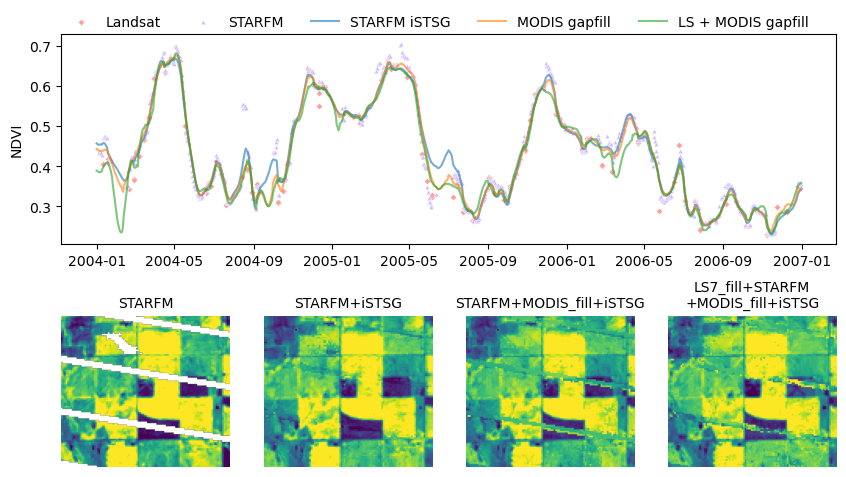

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
import numpy as np
t=100

# Assuming you already have these xarrays:
# starfm, mod_filled, f1 -> with dims ('time', 'y', 'x')
# starfm_mean, mod_filled_mean, f1_mean -> with dims ('time',)

# Compute vmin and vmax
vmin = starfm.ndvi.quantile(0.2).values.item()
vmax = starfm.ndvi.quantile(0.98).values.item()

# Get sorted time steps
time_steps = pd.to_datetime(starfm.time.values)

# Set up the figure
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])
ax_top = fig.add_subplot(gs[0, :])
ax_bottom1 = fig.add_subplot(gs[1, 0])
ax_bottom2 = fig.add_subplot(gs[1, 1])
ax_bottom3 = fig.add_subplot(gs[1, 2])
ax_bottom4 = fig.add_subplot(gs[1, 3])

# Static line plots (do once)
sns.scatterplot(x=landsat_mean.time, y=landsat_mean['ndvi'].values, ax=ax_top, marker = 'D', label='Landsat', s=10, color=pal[3])
sns.scatterplot(x=starfm_mean.time, y=starfm_mean['ndvi'].values, ax=ax_top, marker = '^', label='STARFM', s=10, color=pal[4])

sns.lineplot(x=starfm_istsg_mean.time, y=starfm_istsg_mean['ndvi'].values, label='STARFM iSTSG', alpha=0.6, ax=ax_top)
sns.lineplot(x=mod_filled_mean.time, y=mod_filled_mean['ndvi'].values, label='MODIS gapfill', alpha=0.6, ax=ax_top)
sns.lineplot(x=f1_mean.time, y=f1_mean['ndvi'].values, label='LS + MODIS gapfill', alpha=0.6, ax=ax_top)
ax_top.legend(ncol=5, frameon=False, loc=(0, 1))
ax_top.set_xlabel('')
ax_top.set_ylabel('NDVI')

# Placeholders for dynamic content
scatter1 = ax_top.scatter([], [], color='blue')
scatter2 = ax_top.scatter([], [], color='orange')
scatter3 = ax_top.scatter([], [], color='green')

im1 = ax_bottom1.imshow(starfm.isel(time=t).ndvi.values, vmin=vmin, vmax=vmax)
im2 = ax_bottom2.imshow(starfm_istsg.isel(time=t).ndvi.values, vmin=vmin, vmax=vmax)
im3 = ax_bottom3.imshow(mod_filled.isel(time=t).ndvi.values, vmin=vmin, vmax=vmax)
im4 = ax_bottom4.imshow(f1.isel(time=t).ndvi.values, vmin=vmin, vmax=vmax)

ax_bottom1.set_title("STARFM", fontsize=10)
ax_bottom2.set_title("STARFM+iSTSG", fontsize=10)
ax_bottom3.set_title("STARFM+MODIS_fill+iSTSG", fontsize=10)
ax_bottom4.set_title("LS7_fill+STARFM\n+MODIS_fill+iSTSG", fontsize=10)

# Turn off ticks for image subplots
for ax in [ax_bottom1, ax_bottom2, ax_bottom3, ax_bottom4]:
    ax.axis('off')

#plt.text(x=0,y=-100,s='(a) STARFM \n(b) STARFM + iSTSG \n(c) STARFM + MODIS fill + iSTSG \n(d) LS fill + STARFM + MODIS fill + iSTSG')

In [37]:
landsat.sel(time=slice('2006-03-01', '2006-05-31')).time

<xarray.DataArray 'time' (time: 10)> Size: 80B
array(['2006-03-12T16:58:16.573000000', '2006-03-12T16:58:40.546006000',
       '2006-04-13T16:58:51.453081000', '2006-04-13T16:59:15.426094000',
       '2006-04-21T16:57:11.773353000', '2006-04-21T16:57:35.662755000',
       '2006-05-15T16:59:17.457075000', '2006-05-15T16:59:41.430088000',
       '2006-05-23T16:57:15.595580000', '2006-05-23T16:57:39.485898000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 32614
  * time         (time) datetime64[ns] 80B 2006-03-12T16:58:16.573000 ... 200...

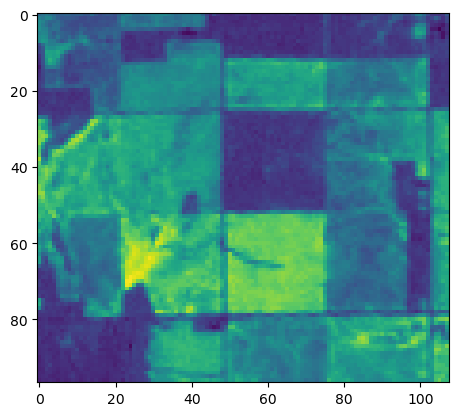

In [38]:
plt.imshow(landsat.sel(time='2006-03-12T16:58:16.573000000').ndvi)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you already have these xarrays:
# starfm, mod_filled, f1 -> with dims ('time', 'y', 'x')
# starfm_mean, mod_filled_mean, f1_mean -> with dims ('time',)

# Compute vmin and vmax
vmin = starfm.ndvi.quantile(0.2).values.item()
vmax = starfm.ndvi.quantile(0.98).values.item()

# Get sorted time steps
time_steps = pd.to_datetime(starfm.time.values)

# Set up the figure
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1])
ax_top = fig.add_subplot(gs[0, :])
ax_bottom1 = fig.add_subplot(gs[1, 0])
ax_bottom2 = fig.add_subplot(gs[1, 1])
ax_bottom3 = fig.add_subplot(gs[1, 2])
ax_bottom4 = fig.add_subplot(gs[1, 3])

# Static line plots (do once)

sns.scatterplot(x=landsat_mean.time, y=landsat_mean['ndvi'].values, ax=ax_top, marker = 'D', label='Landsat', s=10, color=pal[3])
sns.scatterplot(x=starfm_mean.time, y=starfm_mean['ndvi'].values, ax=ax_top, marker = '^', label='STARFM', s=10, color=pal[4])

sns.lineplot(x=starfm_istsg_mean.time, y=starfm_istsg_mean['ndvi'].values, label='STARFM iSTSG', alpha=0.6, ax=ax_top)
sns.lineplot(x=mod_filled_mean.time, y=mod_filled_mean['ndvi'].values, label='MODIS gapfill', alpha=0.6, ax=ax_top)
sns.lineplot(x=f1_mean.time, y=f1_mean['ndvi'].values, label='LS + MODIS gapfill', alpha=0.6, ax=ax_top)
ax_top.legend(ncol=5, frameon=False, loc=(0, 1))
ax_top.set_xlabel('')
ax_top.set_ylabel('NDVI')

# Placeholders for dynamic content
scatter1 = ax_top.scatter([], [], color='blue')
scatter2 = ax_top.scatter([], [], color='orange')
scatter3 = ax_top.scatter([], [], color='green')

im1 = ax_bottom1.imshow(np.zeros_like(starfm.isel(time=0).ndvi.values), vmin=vmin, vmax=vmax)
im2 = ax_bottom2.imshow(np.zeros_like(starfm_istsg.isel(time=0).ndvi.values), vmin=vmin, vmax=vmax)
im3 = ax_bottom3.imshow(np.zeros_like(mod_filled.isel(time=0).ndvi.values), vmin=vmin, vmax=vmax)
im4 = ax_bottom4.imshow(np.zeros_like(f1.isel(time=0).ndvi.values), vmin=vmin, vmax=vmax)

ax_bottom1.set_title("STARFM", fontsize=10)
ax_bottom2.set_title("STARFM+iSTSG", fontsize=10)
ax_bottom3.set_title("STARFM+MODIS_fill+iSTSG", fontsize=10)
ax_bottom4.set_title("LS7_fill+STARFM\n+MODIS_fill+iSTSG", fontsize=10)

# Turn off ticks for image subplots
for ax in [ax_bottom1, ax_bottom2, ax_bottom3, ax_bottom4]:
    ax.axis('off')

# Animation update function
def update(frame_idx):
    t = time_steps[frame_idx]

    # Update scatter points
    scatter1.set_offsets([[t, float(starfm_istsg_mean.sel(time=t).ndvi.values)]])
    scatter2.set_offsets([[t, float(mod_filled_mean.sel(time=t).ndvi.values)]])
    scatter3.set_offsets([[t, float(f1_mean.sel(time=t).ndvi.values)]])

    # Update images
    im1.set_array(starfm.sel(time=t).ndvi.values)
    im2.set_array(starfm_istsg.sel(time=t).ndvi.values)
    im3.set_array(mod_filled.sel(time=t).ndvi.values)
    im4.set_array(f1.sel(time=t).ndvi.values)
    

    return [scatter1, scatter2, scatter3, im1, im2, im3, im4]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(time_steps), blit=False)

# Save to MP4
ani.save(f"ndvi_fusion_timelapse_{site}.mp4", writer='ffmpeg', fps=8, dpi=150)

plt.close()


In [10]:
esfm = utils.load_dataset(f'gs://rangelands-dev/Flux_Towers_v2/{site}/baseline/estarfm/estarfm.nc')
esfm = esfm.sel(time=slice(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-12-31')))
esfm['ndvi'] = (esfm['nir08'] - esfm['red'])/ (esfm['nir08'] + esfm['red'])
esfm = esfm[['ndvi']]
esfm['ndvi'] = esfm['ndvi'].where((esfm['ndvi']>0) & (esfm['ndvi']<1))

esfm_mean = esfm.mean(dim=['y', 'x'])

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming you already have these xarrays:
# starfm, mod_filled, f1 -> with dims ('time', 'y', 'x')
# starfm_mean, mod_filled_mean, f1_mean -> with dims ('time',)

# Compute vmin and vmax
vmin = starfm.ndvi.quantile(0.2).values.item()
vmax = starfm.ndvi.quantile(0.98).values.item()

# Get sorted time steps
time_steps = pd.to_datetime(np.sort(np.union1d(esfm.time.values, starfm.sel(time=slice(pd.to_datetime('2004-01-01'), pd.to_datetime('2006-01-01'))).time.values)))

# Set up the figure
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
ax_top = fig.add_subplot(gs[0, :])
ax_bottom1 = fig.add_subplot(gs[1, 0])
ax_bottom2 = fig.add_subplot(gs[1, 1])

# Static line plots (do once)

sns.scatterplot(x=landsat_mean.time, y=landsat_mean['ndvi'].values, ax=ax_top, marker = 'D', label='Landsat', s=10, color=pal[0])
sns.scatterplot(x=starfm_mean.time, y=starfm_mean['ndvi'].values, ax=ax_top, marker = '^', label='STARFM', s=10, color=pal[1])
sns.scatterplot(x=esfm_mean.time, y=esfm_mean['ndvi'].values, ax=ax_top, marker = '*', label='ESTARFM', s=10, color=pal[2])


ax_top.legend(ncol=5, frameon=False, loc=(0, 1))
ax_top.set_xlabel('')
ax_top.set_ylabel('NDVI')

im1 = ax_bottom1.imshow(np.zeros_like(starfm.isel(time=0).ndvi.values), vmin=vmin, vmax=vmax)
im2 = ax_bottom2.imshow(np.zeros_like(esfm.isel(time=0).ndvi.values), vmin=vmin, vmax=vmax)

ax_bottom1.set_title("STARFM", fontsize=10)
ax_bottom2.set_title("ESTARFM", fontsize=10)

# Turn off ticks for image subplots
for ax in [ax_bottom1, ax_bottom2]:
    ax.axis('off')

# Animation update function
def update(frame_idx):
    t = time_steps[frame_idx]

    # Update images
    try:
        im1.set_array(starfm.sel(time=t).ndvi.values)
    except:
        im1.set_array(np.zeros_like(starfm.isel(time=0).ndvi.values))
    try:    
        im2.set_array(esfm.sel(time=t).ndvi.values)
    except:
        im2.set_array(np.zeros_like(esfm.isel(time=0).ndvi.values))
    
    return [scatter1, scatter2, im1, im2]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(time_steps), blit=False)

# Save to MP4
ani.save(f"ndvi_sfm_esfm_timelapse_{site}.mp4", writer='ffmpeg', fps=8, dpi=150)

plt.close()
